## SETTING

In [1]:
data_path = "C:/Users/yesol/머신러닝/파이썬_머신러닝_완벽가이드/프로젝트/data"
file_name = "test1.txt"

<h1 style="color:red">KAKAOTALK</h1>

## 카카오톡 파일 처리 함수

In [2]:
import os
os.chdir(data_path);

        
def conversation_to_list(kakaotalk_file_name, Month, Day, AM, Hour, Minute):
    
    length_of_list = 20
    name_list = []
    talk_list = []
    
    f = open(kakaotalk_file_name,'rt',encoding='UTF8');
    lines = f.readlines()
    #check Month, Day, Hour, Minute and choose 20 words
    temp_lines = []
    m=0
    d=0
    c=0
    for line in lines:
        if(line.find(str(Month)+"월 "+str(Day)+"일") !=-1 and line.find('[')==-1):
            m=1
        if(m==1 and AM and line.find("오전 "+str(Hour)+":"+Minute)!=-1):
            d=1
        if(m==1 and not AM and line.find("오후 "+str(Hour)+":"+Minute)!=-1):
            d=1
        if(m==1 and d==1):
            temp_lines.append(line)
            c += 1
        if(c== length_of_list):
            break
    lines = temp_lines
    
    # get lines 
    for line in lines:    
        if(line.find('[')==0):
            index1 = line.find('[') +1
            index2 = line.find(']')
            index3 = line.find(']',index2+1) +1

            name2 = line[index1:index2]
            name_list.append(name2)
            talk_list.append(line[index3+1:])

    f.close()

    return name_list, talk_list


## 파파고 번역 함수

In [3]:
import requests
# 파파고 스트링 번역

def papago_translate(context):
    try:
        USER_ID = "svrfjDI6SLeRFekWQEOz" # 개발자센터에서 발급받은 Client ID 값
        USER_SECRET = "JLKglR7QQM" # 개발자센터에서 발급받은 Client Secret 값
        url = "https://openapi.naver.com/v1/papago/n2mt"
        headers= {"X-Naver-Client-Id": USER_ID, "X-Naver-Client-Secret":USER_SECRET}
        params = {"source": "ko", "target": "en", "text": context}
        response = requests.post(url, headers=headers, data=params)
        res = response.json()
        return res['message']['result']['translatedText']
    except:
        return "PAPAGO_FAILED"

# talk_list 번역
def conv_translate(talk_list):
    translated_list = []
    for i in talk_list:
        new = papago_translate(i)
        translated_list.append(new)
    return translated_list


## 감정 계산 함수

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def make_sent_list(trans_list):
    sent_list = []
    senti_analyzer = SentimentIntensityAnalyzer()
    for i in trans_list:
        score=senti_analyzer.polarity_scores(i)['compound']
        sent_list.append(score)
    return sent_list
    
    
def chat_labeling(score):
    if score>=0.3:
        return 'Good'
    elif score<=-0.3:
        return 'Bad'
    else:
        return "SoSo"


## Plot 함수

In [5]:
# Make df for plotting
import pandas as pd
def make_sent_df(name_list, sent_list, decreasing):
    #declare return df
    df = pd.DataFrame()
    
    unique_name = list(set(name_list))
    unique_name.sort()
    # append person
    for person in  unique_name:
        df[person] = sent_list

    # not talker dealing
    for i in df.index:
        for c in df.columns:
            if name_list[i] != c:
                df.loc[i,c] = 100
    df.loc[-1,]= 0
    df =df.sort_index()        
    for i in df.index:
        for c in df.columns:
            if df.loc[i,c] == 100:
                prev = df.loc[i-1,c]
                if prev <0.05 and prev>-0.05:
                     df.loc[i,c]=0
                elif prev>0:
                    df.loc[i,c] = df.loc[i-1,c]-decreasing
                else:
                    df.loc[i,c] = df.loc[i-1,c]+decreasing
    df.loc[len(df)-1,]= df.loc[len(df)-2,]
    df.loc[len(df)-2,]= df.loc[len(df)-3,]
    return df
        
# Plotting
from scipy.interpolate import interp1d
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def plot_time_sentiment(df, time):
    
    new_index = np.arange(-1, len(df)-2, 0.01)
    df2 = pd.DataFrame(index = new_index)
    
    s = ''.join(df.columns)

    
    for c in df.columns:
        f1 = interp1d(df.index, df[c], kind='cubic')
        df2[c] = f1(new_index)
     
    df2.index = new_index
    
    ax2 = df2.plot.line()
    ax2.set_title(time)
    ax2.set_xlabel("time")
    ax2.set_ylabel("Sentiment")

<h1 style="color:red">MAIN</h1>

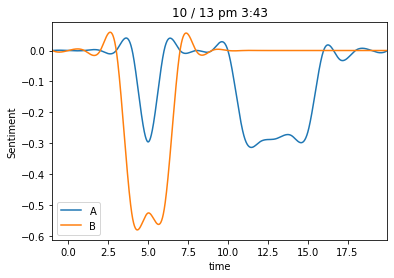

In [6]:
import pandas as pd

# set time
Month = 10
Day = 13
AM = False
Hour = 3
Minute ="43"


#read file
name_list, talk_list=conversation_to_list(file_name,Month,Day,AM,Hour,Minute)

#translate
trans_list = conv_translate(talk_list[0:20])
name_list = conv_translate(name_list)

#make df
df_chat = pd.DataFrame([name_list,talk_list,trans_list], index=['name','ko','en']).T
df_chat['sent']=make_sent_list(df_chat['en'])
df_chat['labeling']=df_chat['sent'].apply(lambda x:chat_labeling(x))

df_chat

#plot
if AM:
    time = str(Month) +" / " +str(Day) +" am " + str(Hour) +":"+str(Minute)
else:
    time = str(Month) +" / " +str(Day) +" pm " + str(Hour) +":"+str(Minute)
df_for_plot = make_sent_df(df_chat['name'], df_chat['sent'], 0.01)
plot_time_sentiment(df_for_plot, time)    


In [7]:
df_chat

,name,ko,en,sent,labeling
0,A,야야야야\n,Yaya,0.0000,SoSo
1,B,왜?\n,Why?,0.0000,SoSo
2,A,저번에 너가 나 컴퓨터 조립해줬잖아\n,"Last time, you put me together with a computer.",0.0000,SoSo
3,B,웅 한 두달 전에 그랬나?\n,Did you do that a couple months ago?,0.0000,SoSo
4,B,고장남? 무슨 일인데?\n,Is it broken? What's going on?,-0.5362,Bad
5,A,아니 그건 아니고... 내가 그때 최신 사양으로 해달랬잖아\n,"No, it's not... I told you to make it up to date.",-0.2960,SoSo
6,A,근데...\n,But...,0.0000,SoSo
7,B,???\n,???,0.0000,SoSo
8,A,왜 이거 옛날 부품이야?\n,Why is this old part?,0.0000,SoSo
9,B,뭔 소리야 옛날꺼라니?\n,"What are you talking about, old?",0.0000,SoSo


## 평균 감정 점수 Dictionary 생성

In [8]:
from collections import Counter

In [9]:
def get_avg_emotion(name_list, sent_list) :
    
    # initialize avg_emotion_dict
    avg_emotion_dict = dict()
    key_list = list(set(name_list))
    for key in key_list :
        avg_emotion_dict[key] = 0
        
    # count all item in name_list
    count_list = Counter(name_list)

    # calculate avg_emotion_score using dictionary
    for index, value in enumerate(name_list):
        avg_emotion_dict[value] += sent_list[index]
    
    for key, value in count_list.items():
        avg_emotion_dict[key] = avg_emotion_dict[key] / value
        
    
    return avg_emotion_dict
    

In [10]:
sent_list = make_sent_list(trans_list)
avg_emotion_dict = get_avg_emotion(name_list, sent_list)

In [11]:
print("평균 감정 점수 : ", avg_emotion_dict)

평균 감정 점수 :  {'A': -0.08961, 'B': -0.05362}


## 감정 변화가 클 때 이전 사람이 하는 말 찾기
기준 - 대화 내에서 대상자의 평균 감정 점수

In [12]:
# return 값 타입 미정

def get_previous_talk(name_list, sent_list, talk_list):
    
    # initialize prevs_dict
    # prevs_dict = {'이름' : ['말', '점수'], '이름' : ['말', '점수'], ...}
    distinct_list = list(set(name_list))  
    prevs_dict = dict()
    for name in distinct_list :
        temp_list = list()
        temp_list.append(talk_list[name_list.index(name)])
        temp_list.append(sent_list[name_list.index(name)])
        prevs_dict[name] = temp_list
    
    
    # find previous sentence
    for index, value in enumerate(name_list):
        
        if abs(sent_list[index] - prevs_dict[value][1]) > abs(avg_emotion_dict[value]) :
            
            # large variation of emotion
            temp_dict = prevs_dict
            del temp_dict[value]
            print(ㅍtalk_list[index], "-> 이전에 나온 말들 : ", temp_dict)
            print()
        
        # update prevs_score
        temp_list = list()
        temp_list.append(talk_list[index])
        temp_list.append(sent_list[index])
        prevs_dict[value] = temp_list
    

In [13]:
get_previous_talk(name_list, sent_list, talk_list)

고장남? 무슨 일인데?
 -> 이전에 나온 말들 :  {'A': ['저번에 너가 나 컴퓨터 조립해줬잖아\n', 0.0]}

아니 그건 아니고... 내가 그때 최신 사양으로 해달랬잖아
 -> 이전에 나온 말들 :  {'B': ['고장남? 무슨 일인데?\n', -0.5362]}

근데...
 -> 이전에 나온 말들 :  {'B': ['고장남? 무슨 일인데?\n', -0.5362]}

???
 -> 이전에 나온 말들 :  {'A': ['근데...\n', 0.0]}

램도 별로고
 -> 이전에 나온 말들 :  {'B': ['뭔 소리야 옛날꺼라니?\n', 0.0]}

컴공 다니는 오빠 있는데 내꺼 보더니 그러더라고
 -> 이전에 나온 말들 :  {'B': ['아니 그보다 누가 그런 이야기 해준거야?\n', 0.0]}

